In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName('Python Spark SQL basic example')\
        .config('spark.some.config.option', 'some-value')\
        .getOrCreate()

### Create json file using spark
# SparkContext로 객체 생성
sc = spark.sparkContext

In [ ]:
df = spark.createDataFrame(
    [
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ],
    ['id', 'weight', 'height', 'age', 'gender']
)

In [18]:
print('Count of rows : {0}'.format(df.count()))
print('Count of distinct rows : {0}'.format(df.distinct().count()))

Count of rows : 7
Count of distinct rows : 6


In [19]:
# dropDuplicate() 함수로 중복 제거 가능
df = df.dropDuplicates()

In [20]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [21]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(
    df.select([c for c in df.columns if c != 'id']).distinct().count()
))

Count of ids: 6
Count of distinct ids: 5


In [22]:
# dropDuplicate() 함수 사용해서 중복 제거 그러나 ID 컬럼을 제외한 나머지 컬럼을 명시한 서브셋 파라미터를 추가해야함
df = df.dropDuplicates(
    subset=[c for c in df.columns if c != 'id']
)
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [23]:
import pyspark.sql.functions as fn 

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

KeyboardInterrupt: 

In [ ]:
# new_id 를 주기
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



In [ ]:
# 미관찰 값 카테고리로 다루기
df_miss = spark.createDataFrame([
    (1, 143.5, 5.6, 28, 'M', 100000),
    (2, 167.2, 5.4, 45, 'M', None),
    (3, None, 5.2, None, None, None),
    (4, 144.5, 5.9, 33, 'M', None),
    (5, 133.2, 5.7, 54, 'F', None),
    (6, 124.1, 5.2, None, 'F', None),
    (7, 129.2, 5.3, 42, 'M', 76000),
],
['id', 'weight', 'height', 'age', 'gender', 'income'])

In [ ]:
# 미관찰 값 개수 파악
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [ ]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



In [ ]:
# 미관찰 값의 비율
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing') for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [ ]:
df_miss_no_income = df_miss.select(
    [c for c in df_miss.columns if c != 'income']
)

In [ ]:
# 행 전체를 제거하는 방법도 있다.
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [ ]:
# fillna로 결측치를 채우는 방법도 있다.
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c)
    for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



## 기술통계
기술 통계는 데이터셋에서의 관찰 값 개수, 각 컬럼의 평균과 표준 편차 또는 최댓값/최솟값 등의 기본적인 정보를 제공한다.

In [ ]:
import pyspark.sql.types as typ

In [ ]:
fraud = sc.textFile('./data/ccFraud.csv.gz')
header = fraud.first()
fraud = fraud.filter(lambda row: row != header).map(lambda row: [int(elem) for elem in row.split(',')])

In [ ]:
# 데이터프레임 스키마 생성
fields = [
    *[typ.StructField(h[1:-1], typ.IntegerType(), True) for h in header.split(',')]
]

schema = typ.StructType(fields)

In [ ]:
fraud_df = spark.createDataFrame(fraud, schema)

In [ ]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [ ]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [ ]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [ ]:
# 비대칭도 확인해보기
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



## 상관계수

In [ ]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In [ ]:
# 상관계수 행렬 구하기
n_numerical = len(numerical)
corr = []
for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

In [ ]:
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

신용카드 사기 데이터셋에서 숫자 피처들 간의 상관관계는 거의 없다고 볼 수 있다. <br>
따라서 모든 피처들이 타깃을 설명하는 데 통계적으로 타당하다고 보여지기 때문에 모든 피처들을 모델을 만드는 데 사용할 수 있다.

## 시각화

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import bokeh.plotting as chrt
from bokeh.io import output_notebook

output_notebook()

# %matplotlib inline 과 the output_notebook()은 모든 차트가 분리된 창이 아닌 파이썬 노트북 내에서 나타나도록 한다.

Loading BokehJS ...

### 히스토그램

In [ ]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 1.0, "Histogram of 'balance'")

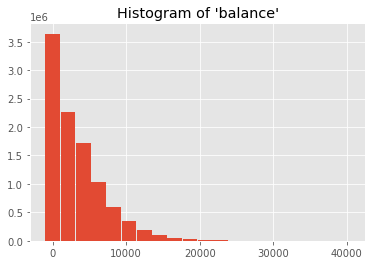

In [ ]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

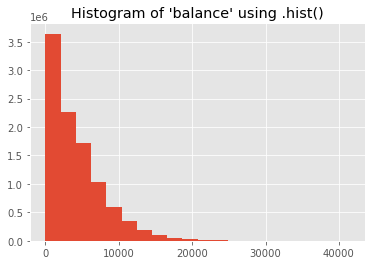

In [ ]:
# create histogram
data_driver = {
    'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()
}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

## 피처 사이의 상호작용
Scatter 차트로 동시에 세 개 변수 간의 상호작용을 시각화 할 수 있다.

In [ ]:
# 성별을 기준으로 0.02% 사기 데이터셋을 샘플링
data_sample = fraud_df.sampleBy(
    'gender', {1: 0.0002, 2: 0.0002}
).select(numerical)

In [ ]:
data_multi = dict(
    [(elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical]
)

Text(0, 0.5, 'numTrans')

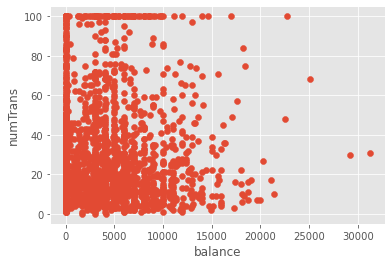

In [26]:
plt.scatter(data_multi['balance'], data_multi['numTrans'])
plt.xlabel('balance')
plt.ylabel('numTrans')